# Plots for CPVT Patients on Beta Blockers

Also exports the tables into a csv for R to parse for Fisher's Exact Test in step 10

In [121]:
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from analysis.database import get_config, get_engine, set_figure_size, \
    FigureParams

In [122]:

sns.set_style("ticks")

In [123]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_09"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [124]:
def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir / f"{name}.{fmt}"), dpi=300)

In [125]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]
df_cpvt_bb = df_cpvt[
    df_cpvt["treatment_taken::Beta blocker"] == 1
    ].copy()

## Treatment Records (ANY)
 Num cpvt patients on any treatment

In [127]:
treatment_cols: list[str] = [
    col for col in df_cpvt.columns if col.startswith("treatment_taken::")
]
treatment_cols

['treatment_taken::Beta blocker',
 'treatment_taken::Catheter ablation',
 'treatment_taken::Enalapril',
 'treatment_taken::Flecainide',
 'treatment_taken::Implantable cardioverter-defibrillator',
 'treatment_taken::Left cardiac sympathetic denervation',
 'treatment_taken::Verapamil']

In [128]:
patient_ids = set()

for col in treatment_cols:
    # Include all patients who have a record of treatment or not treatment
    df_treat = df_cpvt[df_cpvt[col].notna()]
    patient_ids.update(df_treat["individual_id"])

print(f"There are {len(patient_ids)} CPVT patients with a treatment recorded")

There are 601 CPVT patients with a treatment recorded


In [129]:
with get_engine() as engine:
    num_patients = pd.read_sql("""
    SELECT COUNT(DISTINCT patient_id) AS num_patients
    FROM treatment_record tr
    JOIN treatment t
    ON tr.treatment_id = t.treatment_id
    WHERE tr.patient_id IN (
        SELECT individual_id
        FROM cpvt_patients_v
    ) AND
    tr.treatment_taken IS NOT NULL
    """, engine)

num_patients

,num_patients
0,601


In [130]:
print(
    f"Of the {len(patient_ids)} patients with any treatment record, "
    f"{len(df_cpvt_bb)} ({len(df_cpvt_bb) / len(patient_ids) * 100:.2f}%) "
    f"are on beta blockers")

Of the 601 patients with any treatment record, 432 (71.88%) are on beta blockers


## Beta Blocker + Pharmacological Treatment

In [131]:
pharm_treat = [
    'treatment_taken::Enalapril',
    'treatment_taken::Flecainide',
    'treatment_taken::Verapamil'
]

patients_pharm_bb = set()
for col in pharm_treat:
    df_bb_and_pharm = df_cpvt_bb[df_cpvt_bb[col] == 1]
    patients_pharm_bb.update(df_bb_and_pharm["individual_id"])

len(patients_pharm_bb)

131

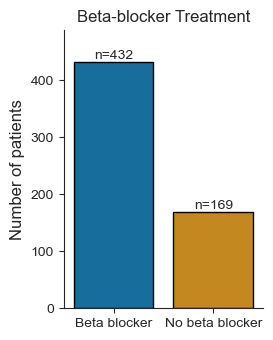

In [132]:
def plot_counts_df(
        patients_group_a: int,
        patients_group_b: int,
        *,
        group_a: str,
        group_b: str,
        panel: FigureParams,
        figname: str
):
    df_counted = pd.DataFrame(
        [
            {
                "group": group_a,
                "num_patients": patients_group_a
            },
            {
                "group": group_b,
                "num_patients": patients_group_b
            }
        ],
    )

    plt.figure(figsize=panel.fig_size)

    ax = sns.barplot(
        data=df_counted,
        x="group",
        y="num_patients",
        palette=sns.color_palette(get_config().figure_palette.cat_palette, 2),
        edgecolor="black",
        hue="group",
        hue_order=[group_a, group_b],
        legend=False
    )

    add_bar_label(ax, panel)
    set_figure_size(
        panel
    )

    save_current_plot(figname)


def add_bar_label(curr_ax: plt.Axes, panel: FigureParams):
    for container_ in curr_ax.containers:
        curr_ax.bar_label(
            container_,
            fmt="n=%g",
            fontsize=panel.text_fontsize,
        )

    # adjust y axis
    y_min, y_max = curr_ax.get_ylim()
    curr_ax.set_ylim(y_min, (y_max - y_min) * 0.075 + y_max)


plot_counts_df(
    len(set(df_cpvt_bb["individual_id"])),
    len(
        patient_ids - set(df_cpvt_bb["individual_id"])
    ),
    group_a="Beta blocker",
    group_b="No beta blocker",
    panel=get_config().s_figure_treatments.panels["bb_vs_non_bb"],
    figname="beta_blocker",
)

In [133]:
invasive_treat = [
    'treatment_taken::Catheter ablation',
    'treatment_taken::Implantable cardioverter-defibrillator',
    'treatment_taken::Left cardiac sympathetic denervation',
]

patients_invasive_bb = set()
for col in invasive_treat:
    df_bb_and_invasive = df_cpvt_bb[df_cpvt_bb[col] == 1]
    patients_invasive_bb.update(df_bb_and_invasive["individual_id"])

len(patients_invasive_bb)

129

## Beta Blocker + Any other

In [134]:
# get number of patients on each treatment
treatments = {
    # "Beta blocker": "Beta blocker",
    "Catheter ablation": "Catheter\nablation",
    "Enalapril": "Enalapril",
    "Flecainide": "Flecainide",
    "Implantable cardioverter-defibrillator": "ICD",
    "Left cardiac sympathetic denervation": "Left cardiac\nsympathetic\ndenervation",
    "Verapamil": "Verapamil"
}

treatment_nums = []

for treatment, plt_name in treatments.items():
    treatment_nums.append({
        "treatment": plt_name,
        "num_patients": df_cpvt_bb[f"treatment_taken::{treatment}"].sum()
    })

treatment_nums = pd.DataFrame(treatment_nums)
treatment_nums = treatment_nums.sort_values(by="num_patients", ascending=False)

treatment_nums

,treatment,num_patients
2,Flecainide,117.0
3,ICD,115.0
5,Verapamil,27.0
4,Left cardiac\nsympathetic\ndenervation,22.0
0,Catheter\nablation,10.0
1,Enalapril,2.0


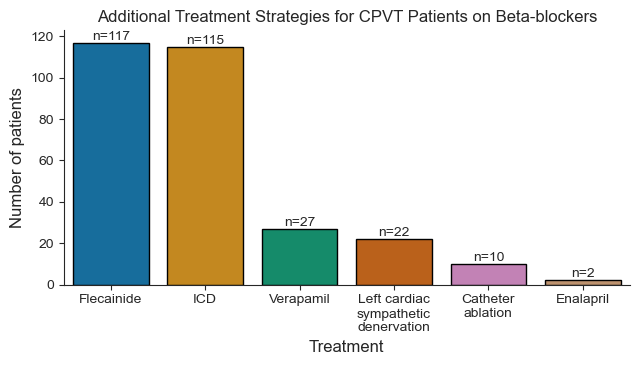

In [135]:
s_figure_2 = get_config().s_figure_3

sns.set_style("ticks")

plt.figure(figsize=s_figure_2.fig_size)
colors = get_config().figure_palette
ax = sns.barplot(data=treatment_nums, x="treatment", y="num_patients",
                 palette=colors.cat_palette,
                 # color=colors.default_bar,
                 edgecolor="black",
                 hue="treatment",
                 legend=False
                 )

for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt="n=%g",
                 fontsize=colors.text_fontsize)
#ax.bar_label(ax.containers[0], label_type='edge', fmt="n=%g")

set_figure_size(
    s_figure_2,
)

save_current_plot("treatment_strategies_all_cpvt")

plt.show()

## Export Data for R

Export tables to do Fisher's Exact Test in R

ORIGINAL:

R420Q
R420W
G357S
G3946S
S2246L
G2337V

In [136]:
# only variants with more than 10 patients
variants_by_bb_usage = pd.DataFrame(df_cpvt_bb.groupby(
    "p_hgvs_aa1"
)["individual_id"].count().sort_values(ascending=False))
# rename (number of bb patients to Total (number of patients on bb)
variants_by_bb_usage.columns = ["Total"]

# rename to p_hgvs_string
variants_by_bb_usage.index.name = "p_hgvs_string"

variants_by_bb_usage.to_csv(
    os.path.join(figures_dir / "all_variant_bb_list.csv")
)

variants_by_bb_usage.head()

,Total
p_hgvs_string,
G357S,94
R420Q,24
G2337V,21
R420W,17
M3978I,14


In [137]:
TOP_N_VARIANTS = 4
# only get the top (N) variants by usage + S2246L (another known variant but want to see if it's significant)
SELECTED_VARIANTS = [
    "S2246L",
    "C2277R"
]

variants_top_by_bb_usage = pd.concat(
    [
        variants_by_bb_usage.head(TOP_N_VARIANTS),
        variants_by_bb_usage[
            variants_by_bb_usage.index.isin(SELECTED_VARIANTS)]
    ],
)

variants_top_by_bb_usage

,Total
p_hgvs_string,
G357S,94
R420Q,24
G2337V,21
R420W,17
S2246L,9
C2277R,8


In [138]:
def create_fisher_table(
        # the input dataframe
        input_df: pd.DataFrame,
        # what treatment to look at
        treatment_name: str,
        # should be a df with index with the protein HGVS names using AA1 format
        totals_df: pd.DataFrame,
        *,
        other_treatment: str = "beta_blocker",
        treatment_col_name: str = None
):
    treat_and_col_name = f"{treatment_col_name if treatment_col_name else treatment_name}_and_{other_treatment}"

    fish_table = pd.DataFrame(
        input_df[
            (input_df[f"treatment_taken::{treatment_name}"] == 1)
            &
            (input_df["p_hgvs_aa1"].isin(totals_df.index))
            ].groupby("p_hgvs_aa1")["individual_id"].count(),
    )
    fish_table.columns = [treat_and_col_name]

    fish_table = fish_table.join(
        totals_df, how="outer"
    )
    fish_table.fillna(0, inplace=True)
    fish_table[f"{other_treatment}_only"] = (
            fish_table["Total"] - fish_table[
        treat_and_col_name]
    )

    # rename index
    fish_table.index.name = "p_hgvs_string"
    # rearrange columns
    fish_table = fish_table[[
        treat_and_col_name,
        f"{other_treatment}_only",
        "Total"
    ]]
    # set all to int
    fish_table = fish_table.astype(int)

    # remove index and sort by total
    fish_table.reset_index(inplace=True)
    fish_table = fish_table.sort_values(by="Total", ascending=False)

    return fish_table

In [139]:
# get the total number taking flecainide + beta blockers, beta blockers only, total in F + BB
for treatment, fish_name in {
    "Flecainide": "Flecainide",
    "Implantable cardioverter-defibrillator": "ICD",
}.items():
    treatment_and_bb = create_fisher_table(
        df_cpvt_bb,
        treatment,
        variants_top_by_bb_usage,
        treatment_col_name=fish_name
    )

    display(treatment_and_bb)

    treatment_and_bb.to_csv(
        os.path.join(figures_dir / f"cpvt_{fish_name}_bb.csv"),
        index=False
    )

,p_hgvs_string,Flecainide_and_beta_blocker,beta_blocker_only,Total
2,G357S,0,94,94
3,R420Q,2,22,24
1,G2337V,0,21,21
4,R420W,12,5,17
5,S2246L,3,6,9
0,C2277R,6,2,8


,p_hgvs_string,ICD_and_beta_blocker,beta_blocker_only,Total
2,G357S,1,93,94
3,R420Q,13,11,24
1,G2337V,1,20,21
4,R420W,5,12,17
5,S2246L,7,2,9
0,C2277R,1,7,8


## After Flecainide Reccomended by HRS

HRS/EHRA/APHRS Expert Consensus Statement on the Diagnosis and Management of Patients with Inherited Primary Arrhythmia Syndromes: Document endorsed by HRS, EHRA, and APHRS in May 2013 and by ACCF, AHA, PACES, and AEPC in June 2013. https://doi.org/10.1016/j.hrthm.2013.05.014

In [140]:
after_2013 = df_cpvt_bb[df_cpvt_bb["year"] >= 2013]
before_2013 = df_cpvt_bb[df_cpvt_bb["year"] < 2013]

variants_after_2013_bb_usage = pd.DataFrame(after_2013.groupby(
    "p_hgvs_aa1"
)["individual_id"].count().sort_values(ascending=False))

# rename (number of bb patients to Total (number of patients on bb)
variants_after_2013_bb_usage.columns = ["Total"]

# rename to p_hgvs_string
variants_after_2013_bb_usage.index.name = "p_hgvs_string"

variants_after_2013_bb_usage.to_csv(
    os.path.join(figures_dir / "all_variant_list_after_2013.csv")
)

variants_after_2013_bb_usage.head()

,Total
p_hgvs_string,
G357S,91
G2337V,21
R420Q,15
R420W,9
C2277R,8


In [141]:
variants_after_2013_by_bb_usage = pd.concat(
    [
        variants_after_2013_bb_usage.head(TOP_N_VARIANTS),
        variants_after_2013_bb_usage[
            variants_after_2013_bb_usage.index.isin(SELECTED_VARIANTS)]
    ],
)

variants_after_2013_by_bb_usage

,Total
p_hgvs_string,
G357S,91
G2337V,21
R420Q,15
R420W,9
C2277R,8
S2246L,4


In [142]:
f_and_bb_2013 = create_fisher_table(
    after_2013,
    "Flecainide",
    variants_after_2013_by_bb_usage,
)
f_and_bb_2013

,p_hgvs_string,Flecainide_and_beta_blocker,beta_blocker_only,Total
2,G357S,0,91,91
1,G2337V,0,21,21
3,R420Q,1,14,15
4,R420W,7,2,9
0,C2277R,6,2,8
5,S2246L,3,1,4


In [143]:
f_and_bb_2013.to_csv(
    os.path.join(figures_dir / f"flecainide_fisher_2013_and_after.csv"),
    index=False
)

In [144]:
# Compare proportions of F+B before and after 2013
data_cmp = df_cpvt_bb.drop_duplicates("individual_id").copy()
data_cmp["before_2013"] = data_cmp["year"] < 2013
data_cmp = data_cmp.groupby("before_2013").agg(
    {
        "treatment_taken::Flecainide": "sum",
        "treatment_taken::Beta blocker": "sum"
    }
).rename(
    columns={
        "treatment_taken::Flecainide": "Flecainide_and_beta_blocker",
        "treatment_taken::Beta blocker": "Total"
    }
)
data_cmp["Beta_blocker_only"] = data_cmp["Total"] - data_cmp[
    "Flecainide_and_beta_blocker"]

data_cmp = data_cmp[
    ["Flecainide_and_beta_blocker", "Beta_blocker_only", "Total"]]

# rename index
data_cmp.index = ["2013 and after", "Before 2013"]
data_cmp.index.name = "Group"

data_cmp.head()

,Flecainide_and_beta_blocker,Beta_blocker_only,Total
Group,,,
2013 and after,80.0,239.0,319.0
Before 2013,37.0,76.0,113.0


In [145]:
# get number of publicatrions
data_cmp_pub = df_cpvt_bb.copy()
data_cmp_pub["before_2013"] = data_cmp_pub["year"] < 2013
data_cmp_pub = data_cmp_pub[data_cmp_pub["treatment_taken::Flecainide"] == True]

data_cmp_pub = data_cmp_pub.groupby("before_2013").agg(
    {
        "publication_id": "nunique",
        "individual_id": "nunique"
    }
).rename(
    columns={
        "publication_id": "num_publications",
        "individual_id": "num_individuals"
    }
)
data_cmp_pub

,num_publications,num_individuals
before_2013,,
False,36,80
True,6,37


## Plot Percentages

,p_hgvs_string,Flecainide_and_beta_blocker,beta_blocker_only,Total,Flecainide_and_beta_blocker_pct,total_pct
2,G357S,0,91,91,0.000000,100
1,G2337V,0,21,21,0.000000,100
3,R420Q,1,14,15,6.666667,100
4,R420W,7,2,9,77.777778,100
0,C2277R,6,2,8,75.000000,100
5,S2246L,3,1,4,75.000000,100


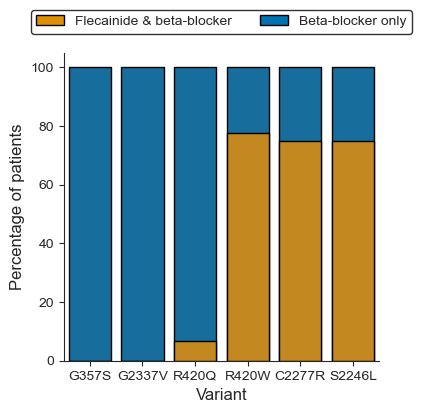

In [146]:
import matplotlib.patches as mpatches

sns.set_style("ticks")


def plot_bb_percentages(
        df_fish: pd.DataFrame,
        panel: FigureParams,
        group_a: str,
        legend_a: str,
        legend_b: str,
        plt_name: str,
        plt_order: list[str] = None,
):
    plt.figure(
        figsize=panel.fig_size
    )

    df_fish_pct = df_fish.copy()
    df_fish_pct[f"{group_a}_pct"] = (
            df_fish[group_a] / df_fish["Total"] * 100
    )
    df_fish_pct["total_pct"] = 100

    display(df_fish_pct)

    color1 = sns.color_palette(colors.cat_palette)[0]
    color2 = sns.color_palette(colors.cat_palette)[1]

    plt_order = plt_order if plt_order else df_fish_pct["p_hgvs_string"]

    sns.barplot(
        x="p_hgvs_string",
        y="total_pct",
        data=df_fish_pct,
        color=color1,
        edgecolor="black",
        order=plt_order
    )
    sns.barplot(
        x="p_hgvs_string",
        y=f"{group_a}_pct",
        data=df_fish_pct,
        color=color2,
        edgecolor="black",
        order=plt_order
    )

    top_bar = mpatches.Patch(
        facecolor=color2,
        label=legend_a,
        edgecolor="black"
    )
    bottom_bar = mpatches.Patch(
        facecolor=color1,
        label=legend_b,
        edgecolor="black"
    )

    plt.legend(
        handles=[top_bar, bottom_bar],
        loc="center",
        bbox_to_anchor=(0.5, 1.1),
        ncol=2,
        edgecolor="black"
    )

    set_figure_size(
        panel
    )
    save_current_plot(plt_name)

    plt.show()


plot_order = f_and_bb_2013["p_hgvs_string"].tolist()

plot_bb_percentages(
    f_and_bb_2013,
    get_config().treatment_pcts.panels["flecainide_pct"],
    "Flecainide_and_beta_blocker",
    "Flecainide & beta-blocker",
    "Beta-blocker only",
    "flecainide_bb_percentages",
    plt_order=plot_order
)

In [147]:
icd_fisher = create_fisher_table(
    df_cpvt_bb,
    "Implantable cardioverter-defibrillator",
    variants_top_by_bb_usage,
    treatment_col_name="ICD"
)

icd_fisher.head()

,p_hgvs_string,ICD_and_beta_blocker,beta_blocker_only,Total
2,G357S,1,93,94
3,R420Q,13,11,24
1,G2337V,1,20,21
4,R420W,5,12,17
5,S2246L,7,2,9


,p_hgvs_string,ICD_and_beta_blocker,beta_blocker_only,Total,ICD_and_beta_blocker_pct,total_pct
2,G357S,1,93,94,1.063830,100
3,R420Q,13,11,24,54.166667,100
1,G2337V,1,20,21,4.761905,100
4,R420W,5,12,17,29.411765,100
5,S2246L,7,2,9,77.777778,100
0,C2277R,1,7,8,12.500000,100


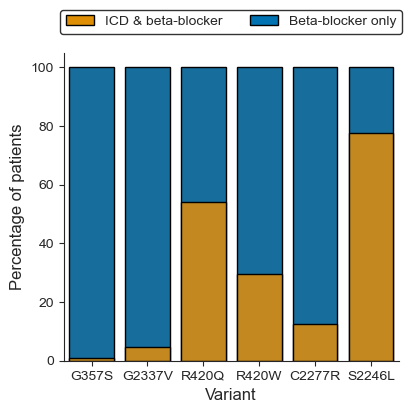

In [148]:
plot_bb_percentages(
    icd_fisher,
    get_config().treatment_pcts.panels["icd_pct"],
    "ICD_and_beta_blocker",
    "ICD & beta-blocker",
    "Beta-blocker only",
    "icd_bb_percentages",
    plt_order=plot_order
)